La organización del trabajo en el notebook

- Cargar las bibliotecas.

* ETL
    * Extraccion
    * Limpieza
    * Transformación
    * Carga
 
- Visualización de los datos.

- Sandbox para hacer experimentaciones.

- Sandbox Legado

- Lecciones aprendidas

En la medida de lo posible trabajar cada sección en una sola celda.

Fín de la iteración

# Cargar las bibliotecas

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats
from calendar import monthrange
import six
import scipy.stats as st

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#warnings.warn(msg, FutureWarning)

# ETL

## Extracción

Se descargó la información correspondiente al día 21/10/2018 desde la base de datos de WifID. La base de datos obtenida fue la del establecimiento:

* El Barista Slow Coffee

Y el archivo obtenido fue el siguiente:

* barista_June-Tuesday-05

Los archivos de texto plano con la información son:

dispositivos.csv
users.csv

## Transformación

In [4]:
dispositivos = pd.read_csv("dispositivos.csv")
users = pd.read_csv("users.csv")
reg_efectivos = pd.DataFrame()

### Limpieza

El primer tipo de limpieza será darle un correcto formato a los datos:

1. Las fechas deben ser datetime
2. Los id_user deben ser str
3. Los macaddr deben ser strings

In [5]:
#Renombrar columnas created y modified para evitar conflictos 
#Convertir fechas a datetime64

dispositivos = dispositivos.rename(columns={'created':'d_created','modified':'d_modified'})
dispositivos['d_created'] = dispositivos['d_created'].astype('datetime64[ns]')
dispositivos['d_modified'] = dispositivos['d_modified'].astype('datetime64[ns]')

#Convertir id_user a str
dispositivos['id_user'] = dispositivos['id_user'].fillna(0)
dispositivos['id_user'] = dispositivos['id_user'].astype(int)
dispositivos['id_user'] = dispositivos['id_user'].astype(str)

#Convertir macaddr a str
dispositivos['macaddr'] = dispositivos['macaddr'].astype(str)

#Eliminar columnas sobrantes
dispositivos = dispositivos.drop(columns=['id','asignado','ultimo_visto','fabricante','ssid','primer_lugar_visto','routermac','potencia'])

In [6]:
#Renombrar columnas created y modified para evitar conflictos 
#Convertir fechas a datetime64

users = users.rename(columns={'created':'u_created','modified':'u_modified'})
users['u_created'] = users['u_created'].astype('datetime64[ns]')
users['u_modified'] = users['u_modified'].astype('datetime64[ns]')

#Convertir id_user a str
users = users.rename(columns={'id':'id_user'})
users['id_user'] = users['id_user'].fillna(0)
users['id_user'] = users['id_user'].astype(int)
users['id_user'] = users['id_user'].astype(str)

#Convertir macaddr a str
users['macaddr'] = users['macaddr'].astype(str)

#Convertir fecha_nacimiento a datetime64
users['fecha_nacimiento'] = pd.to_datetime(users['fecha_nacimiento'], errors = 'coerce')

#Eliminar columnas sobrantes
users = users.drop(columns=['nombre','apellidos','presente','password','username','control_ausencia','estado','ultimo_visto','ultimo_ingreso','celular','cedula','coins'])

# Eliminar filas con valores nulos
users = users.dropna()

## Transformación

A continuación se definen los criterios para que las tablas sean manipulables por esto es importante que los datos cumplan con los siguientes requisitos.

1. Las fechas de modificación deben ser mayores o iguales a las de creación para cada tabla.
2. La fecha de creación de los usuarios registrados debe ser mayor o igual a la fecha de creación de los dispositivos.
3. Sólo se captura el primer registro de un usuario. Si un usuario ya se encontraba registrado este no se volverá a tomar de nuevo.
4. A un usuario solo le corresponde un solo dispositivo.

Un registro efectivo se denota en la tabla como un valor booleano en la columna 'reg_efectivo'

In [7]:
#Devuelve el valor esperado
#Recibe una columna de una DataFrame
def expected_value(X):
    N = X.count()
    f = X.value_counts()
    P = f/N
    Ei = P.index*P
    E = Ei.sum()
    return E

In [8]:
dispositivos = dispositivos[dispositivos['d_modified'] >= dispositivos['d_created']]

In [9]:
users = users.sort_values(by='u_created')
users = users[users['u_modified'] >= users['u_created']]
users = users[users['rol'] == 'reg']
users = users[users['email'].notnull()]

# Por fin pude aplicar lower a una columna
users = users.apply(lambda x : x.str.lower() if x.name in ['email'] else x)
users = users.drop_duplicates(subset='email', keep='first')

In [10]:
reg_efectivos = pd.merge(dispositivos, users, on=['id_user','macaddr'], how='outer')
reg_efectivos.sort_values(by='u_created')
reg_efectivos = reg_efectivos[reg_efectivos['u_created'] >= reg_efectivos['d_created']]
reg_efectivos['id'] = reg_efectivos.index

#Se crean las columnas del día de la semana y el valor esperado para dicho día
reg_efectivos['u_created_dayofweek'] = reg_efectivos['u_created'].dt.dayofweek + 1
reg_efectivos['u_created_dayofweek_expected_value'] = reg_efectivos['u_created_dayofweek'].expanding(1).apply(expected_value,raw=False)

#Se crean las columnas de hora y el valor esperado para la hora
reg_efectivos['u_created_hour'] = reg_efectivos['u_created'].dt.hour
reg_efectivos['u_created_hour_expected_value'] = reg_efectivos['u_created_hour'].expanding(1).apply(expected_value,raw=False)

#Se obtienen las fechas sin hora para mostrarlos en los ejes de las abscisas de las distintas gráficas
reg_efectivos['u_created_date'] = reg_efectivos['u_created'].dt.date

#Se obtienen las fechas por día del año
reg_efectivos['created_dayofyear'] = reg_efectivos['u_created'].dt.dayofyear

#Se obtienen los nombres de los dias para mostrarlos en los ejes de las abscisas de las distintas gráficas
reg_efectivos['u_created_dayname'] = reg_efectivos['u_created'].dt.day_name()

#Se obtienen los trimestres para 
reg_efectivos['u_created_quarter'] = reg_efectivos['u_created'].dt.quarter

# Obtener el año de las personas que son más proclives a generar registros efectivos
reg_efectivos['ano_fecha_nacimiento'] = reg_efectivos['fecha_nacimiento'].dt.year

In [11]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

# render_mpl_table(df, header_columns=0, col_width=2.0)

### Eliminación de los valores atípicos

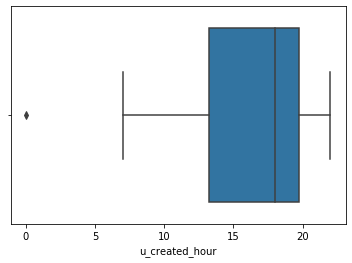

In [12]:
ax = sns.boxplot(x="u_created_hour", data=reg_efectivos)

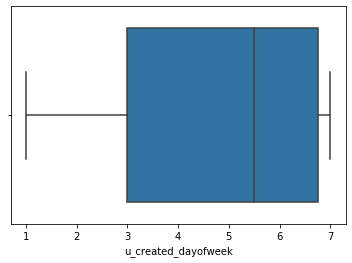

In [13]:
ax = sns.boxplot(x="u_created_dayofweek", order=["Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], data=reg_efectivos)

In [14]:
# Eliminar los datos atípicos de u_created_hour

Q1 = reg_efectivos['u_created_hour'].quantile(0.25)
Q3 = reg_efectivos['u_created_hour'].quantile(0.75)
IQR = Q3 - Q1
reg_efectivos = reg_efectivos[~((reg_efectivos['u_created_hour'] < (Q1 - 1.5 * IQR)) |(reg_efectivos['u_created_hour'] > (Q3 + 1.5 * IQR)))]

In [15]:
# Eliminar los datos atípicos de u_created_dayofweek

Q1 = reg_efectivos['u_created_dayofweek'].quantile(0.25)
Q3 = reg_efectivos['u_created_dayofweek'].quantile(0.75)
IQR = Q3 - Q1
reg_efectivos = reg_efectivos[~((reg_efectivos['u_created_dayofweek'] < (Q1 - 1.5 * IQR)) |(reg_efectivos['u_created_dayofweek'] > (Q3 + 1.5 * IQR)))]

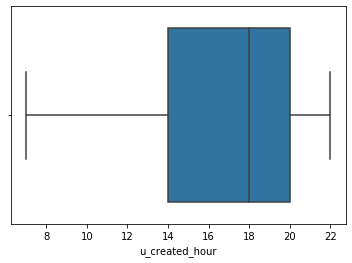

In [16]:
ax = sns.boxplot(x="u_created_hour", data=reg_efectivos)

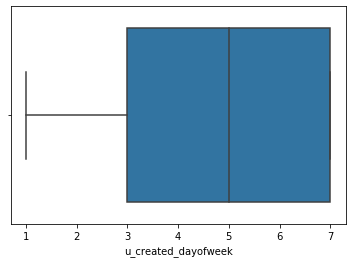

In [17]:
ax = sns.boxplot(x="u_created_dayofweek", order=["Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], data=reg_efectivos)

In [18]:
# Organizar por trimestre y por fecha de creación del usuario
reg_efectivos = reg_efectivos.sort_values(by=['u_created_quarter','u_created'])

# Hallar el día dentro del trimestre
# reg_efectivos['u_created_dayofquarter'] = (reg_efectivos['u_created'] - (reg_efectivos['u_created'].dt.date - pd.tseries.offsets.QuarterBegin(startingMonth=1))).dt.days
reg_efectivos['u_created_dayofquarter'] = (reg_efectivos['u_created'] - ((reg_efectivos['u_created'] + pd.tseries.offsets.DateOffset(days=1)) - pd.tseries.offsets.QuarterBegin(startingMonth=1))).dt.days

# Hallar la hora esperada por trimestre u_created_hour_expected_value_by_quarter
reg_temp = reg_efectivos.groupby(['u_created_quarter'])['u_created_hour'].expanding(1).apply(expected_value,raw=False).reset_index().rename(columns={'level_1':'id','u_created_hour':'u_created_hour_expected_value_by_quarter'})
reg_efectivos = pd.merge(reg_efectivos, reg_temp, on=['id','u_created_quarter'], how='outer')
reg_efectivos = reg_efectivos.set_index('id')

# Hallar el día de la semana esperado por trimestre u_created_dayofweek_expected_value_by_quarter
reg_temp = reg_efectivos.groupby(['u_created_quarter'])['u_created_dayofweek'].expanding(1).apply(expected_value,raw=False).reset_index().rename(columns={'level_1':'id','u_created_dayofweek':'u_created_dayofweek_expected_value_by_quarter'})
reg_efectivos = pd.merge(reg_efectivos, reg_temp, on=['id','u_created_quarter'], how='outer')
reg_efectivos = reg_efectivos.set_index('id')

## Análisis

Histograma de los registros efectivos por dia de la semana

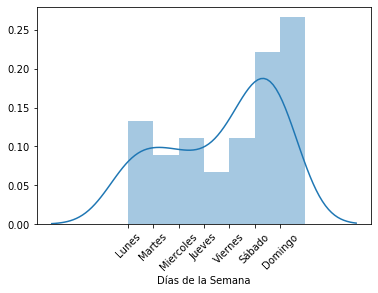

In [19]:
nbins = np.arange(1, 9)
sns.distplot(reg_efectivos['u_created_dayofweek'], bins=nbins, norm_hist=True)
plt.xticks(np.arange(1,8), ('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'), rotation=45)
plt.xlabel("Días de la Semana")
plt.show()

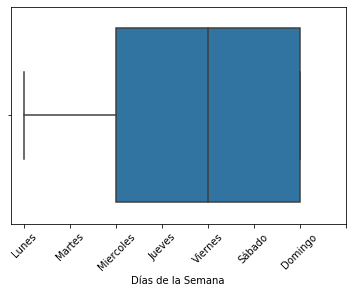

In [20]:
sns.boxplot(x="u_created_dayofweek", order=["Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], data=reg_efectivos)
plt.xticks(np.arange(1,9), ('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'), rotation=45)
plt.xlabel("Días de la Semana")
plt.show()

In [21]:
reg_efectivos['u_created_dayofweek'].mode()

0    7
dtype: int64

In [22]:
reg_efectivos['u_created_dayofweek'].describe()

count    45.000000
mean      4.666667
std       2.174229
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max       7.000000
Name: u_created_dayofweek, dtype: float64

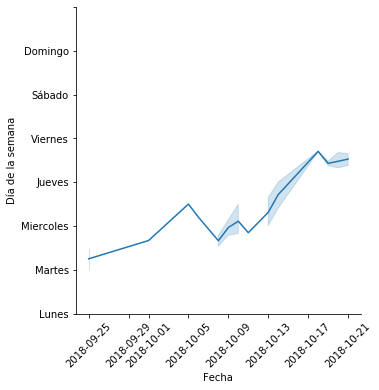

In [23]:
ax = sns.relplot(x="u_created_date", y="u_created_dayofweek_expected_value", data=reg_efectivos, kind='line')
plt.xticks(rotation=45)
plt.yticks(np.arange(1,9), ('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'))
plt.ylabel("Día de la semana")
plt.xlabel("Fecha")
plt.show()

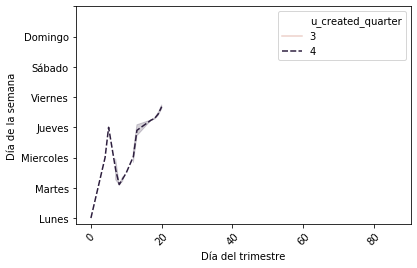

In [24]:
ax = sns.lineplot(x="u_created_dayofquarter", y="u_created_dayofweek_expected_value_by_quarter", data=reg_efectivos,  hue='u_created_quarter', style='u_created_quarter', legend='full')
plt.xticks(rotation=45)
plt.yticks(np.arange(1,9), ('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'))
plt.ylabel("Día de la semana")
plt.xlabel("Día del trimestre")
plt.show()

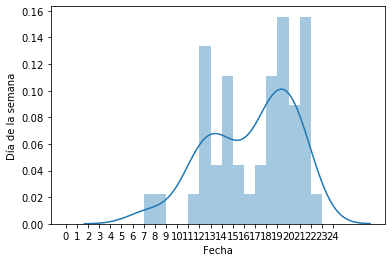

In [25]:
nbins = np.arange(0, 25)
ax = sns.distplot(reg_efectivos['u_created_hour'], bins=nbins, norm_hist=True)
plt.xticks(np.arange(0, 25))
plt.ylabel("Día de la semana")
plt.xlabel("Fecha")
plt.show()

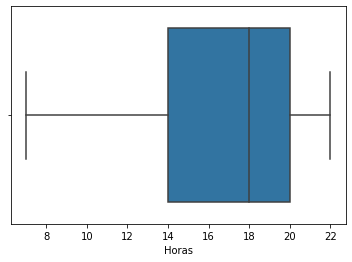

In [26]:
ax = sns.boxplot(x="u_created_hour", data=reg_efectivos)
plt.xlabel("Horas")
plt.show()

In [27]:
reg_efectivos['u_created_hour'].mode()

0    19
1    21
dtype: int64

In [28]:
reg_efectivos['u_created_hour'].describe()

count    45.000000
mean     16.577778
std       3.846420
min       7.000000
25%      14.000000
50%      18.000000
75%      20.000000
max      22.000000
Name: u_created_hour, dtype: float64

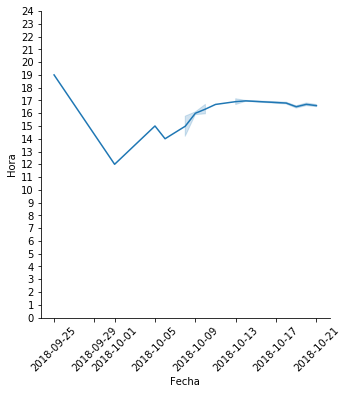

In [29]:
ax = sns.relplot(x="u_created_date", y="u_created_hour_expected_value_by_quarter", data=reg_efectivos, kind='line')

plt.xticks(rotation=45)
plt.yticks(np.arange(0, 25))
plt.ylabel("Hora")
plt.xlabel("Fecha")
plt.show()

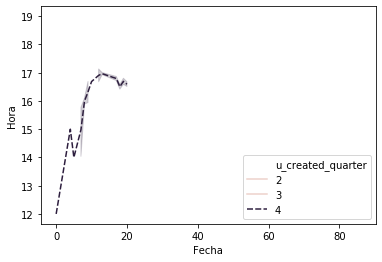

In [30]:
ax = sns.lineplot(x="u_created_dayofquarter", y="u_created_hour_expected_value_by_quarter", data=reg_efectivos,  hue='u_created_quarter', style='u_created_quarter')
plt.ylabel("Hora")
plt.xlabel("Fecha")
plt.show()

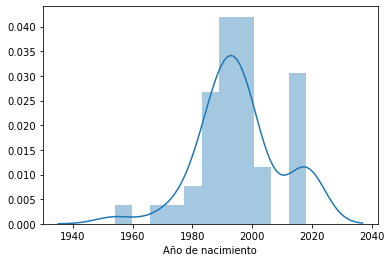

In [31]:
# nbins = np.arange(0, 24)
ax = sns.distplot(reg_efectivos['ano_fecha_nacimiento'], norm_hist=True)
plt.xlabel("Año de nacimiento")
plt.show()

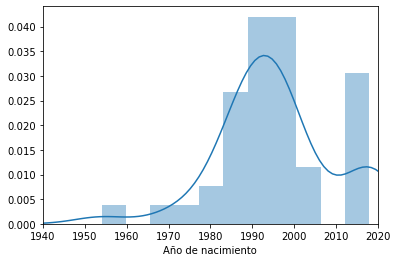

In [32]:
ax = sns.distplot(reg_efectivos['ano_fecha_nacimiento'], norm_hist=True)
plt.xlim([1940,2020])
plt.xlabel("Año de nacimiento")
plt.show()

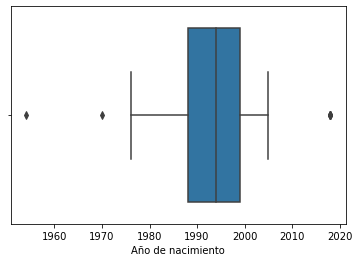

In [33]:
ax = sns.boxplot(x="ano_fecha_nacimiento", data=reg_efectivos)
plt.xlabel("Año de nacimiento")
plt.show()

In [34]:
reg_efectivos['ano_fecha_nacimiento'].describe()

count      45.000000
mean     1995.466667
std        13.694060
min      1954.000000
25%      1988.000000
50%      1994.000000
75%      1999.000000
max      2018.000000
Name: ano_fecha_nacimiento, dtype: float64

In [35]:
reg_efectivos['ano_fecha_nacimiento'].mode()

0    2018
dtype: int64

In [36]:
reg_efectivos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 7138 to 7239
Data columns (total 21 columns):
macaddr                                          45 non-null object
d_created                                        45 non-null datetime64[ns]
d_modified                                       45 non-null datetime64[ns]
id_user                                          45 non-null object
u_modified                                       45 non-null datetime64[ns]
u_created                                        45 non-null datetime64[ns]
rol                                              45 non-null object
email                                            45 non-null object
fecha_nacimiento                                 45 non-null datetime64[ns]
u_created_dayofweek                              45 non-null int64
u_created_dayofweek_expected_value               45 non-null float64
u_created_hour                                   45 non-null int64
u_created_hour_expected_value        

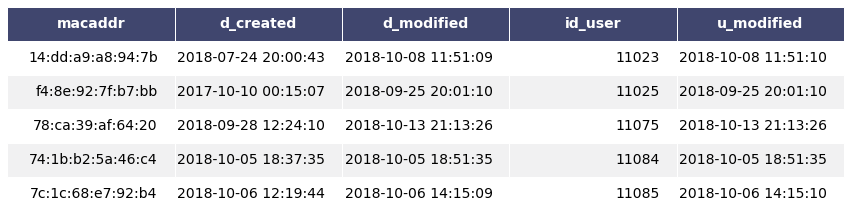

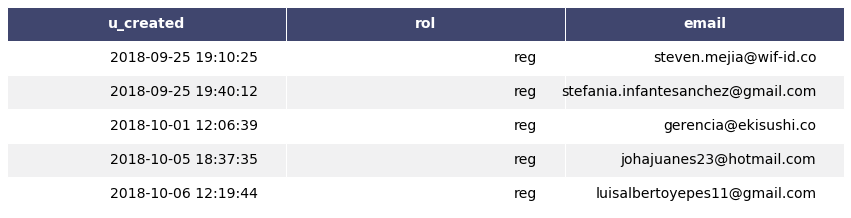

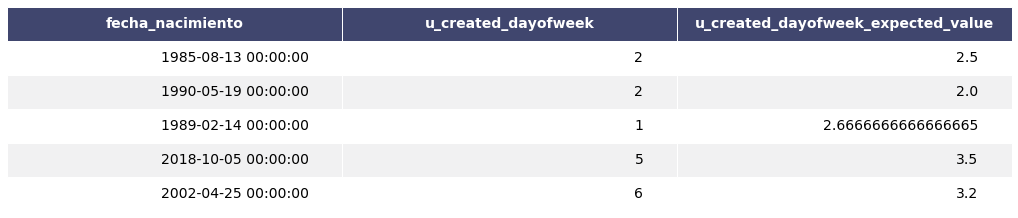

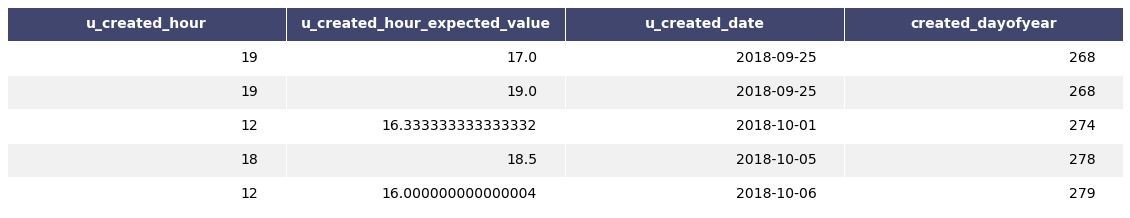

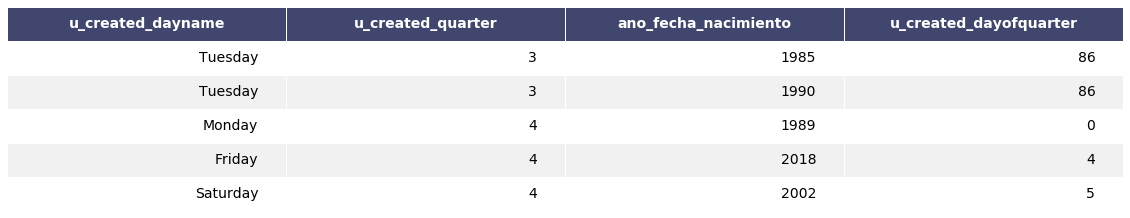

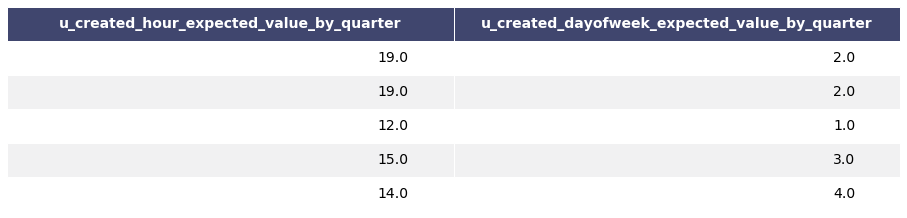

In [37]:
render_mpl_table(reg_efectivos.iloc[:,0:5].head(), header_columns=0, col_width=3.0)
render_mpl_table(reg_efectivos.iloc[:,5:8].head(), header_columns=0, col_width=5.0)
render_mpl_table(reg_efectivos.iloc[:,8:11].head(), header_columns=0, col_width=6.0)
render_mpl_table(reg_efectivos.iloc[:,11:15].head(), header_columns=0, col_width=5.0)
render_mpl_table(reg_efectivos.iloc[:,15:19].head(), header_columns=0, col_width=5.0)
render_mpl_table(reg_efectivos.iloc[:,19:21].head(), header_columns=0, col_width=8.0)

In [38]:
dispositivos

,macaddr,d_created,d_modified,id_user
0,34:e6:ad:64:1c:61,2017-10-20 22:24:35,2017-10-21 20:32:19,0
1,f0:c8:50:0b:2f:f1,2017-10-11 21:50:35,2017-10-11 23:39:48,0
2,a4:ba:76:7a:cd:74,2017-10-12 21:12:03,2017-10-13 23:50:06,0
3,7c:b1:5d:ab:5c:bc,2017-10-21 06:24:18,2017-10-21 20:32:21,0
4,e4:58:b8:b5:1b:a3,2017-10-21 14:58:27,2017-10-21 20:32:27,0
...,...,...,...,...
7250,24:00:ba:f0:43:ef,2018-10-18 08:12:29,2018-10-18 08:17:10,11145
7251,60:be:b5:26:cd:45,2018-10-20 21:06:11,2018-10-20 22:50:07,0
7252,ac:07:5f:97:ab:23,2018-10-21 11:58:11,2018-10-21 11:58:11,0
7253,00:ff:ca:48:38:dd,2018-10-20 16:23:08,2018-10-20 19:41:15,0


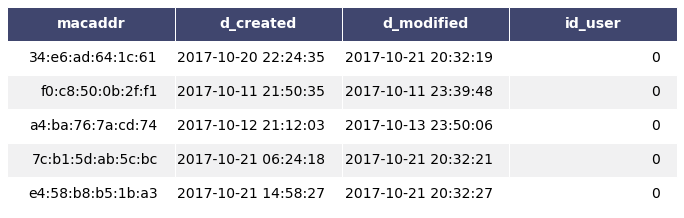

In [39]:
render_mpl_table(dispositivos.iloc[:,0:5].head(), header_columns=0, col_width=3.0)
# render_mpl_table(reg_efectivos.iloc[:,5:8].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,8:11].head(), header_columns=0, col_width=6.0)
# render_mpl_table(reg_efectivos.iloc[:,11:15].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,15:19].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,19:21].head(), header_columns=0, col_width=8.0)

In [41]:
users

,id_user,u_modified,macaddr,u_created,rol,email,fecha_nacimiento
34,11023,2018-10-08 11:51:10,14:dd:a9:a8:94:7b,2018-09-25 19:10:25,reg,steven.mejia@wif-id.co,1985-08-13
19,11025,2018-09-25 20:01:10,f4:8e:92:7f:b7:bb,2018-09-25 19:40:12,reg,stefania.infantesanchez@gmail.com,1990-05-19
58,11075,2018-10-13 21:13:26,78:ca:39:af:64:20,2018-10-01 12:06:39,reg,gerencia@ekisushi.co,1989-02-14
17,11084,2018-10-05 18:51:35,74:1b:b2:5a:46:c4,2018-10-05 18:37:35,reg,johajuanes23@hotmail.com,2018-10-05
3,11085,2018-10-06 14:15:10,7c:1c:68:e7:92:b4,2018-10-06 12:19:44,reg,luisalbertoyepes11@gmail.com,2002-04-25
35,11094,2018-10-08 12:11:13,ec:10:7b:e3:1b:b7,2018-10-08 12:08:55,reg,carolinavanegascorrea@gmail.com,2018-01-19
43,11095,2018-10-08 20:07:13,48:bf:6b:d6:d8:20,2018-10-08 18:50:33,reg,diatomita82@hotmail.com,1982-07-21
39,11096,2018-10-08 20:54:10,30:a8:db:d5:8e:aa,2018-10-08 19:04:34,reg,dayana8587@gmail.com,1987-05-08
44,11097,2018-10-08 20:54:10,7c:1c:68:18:48:65,2018-10-08 19:20:28,reg,yonmarxyz@gmail.com,1988-10-08
33,11098,2018-10-08 20:53:08,50:55:27:b8:a1:50,2018-10-08 19:20:56,reg,carl_24_2@hotmail.com,1986-03-24


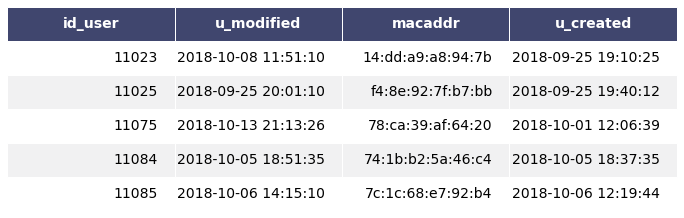

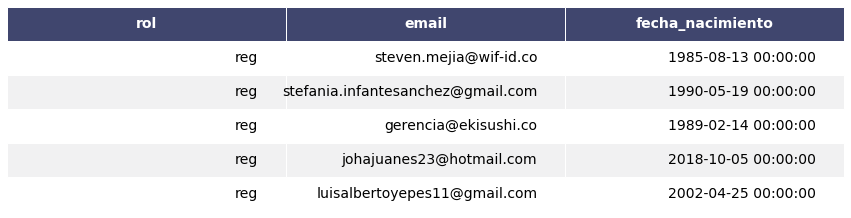

In [43]:
render_mpl_table(users.iloc[:,0:4].head(), header_columns=0, col_width=3.0)
render_mpl_table(users.iloc[:,4:8].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,8:11].head(), header_columns=0, col_width=6.0)
# render_mpl_table(reg_efectivos.iloc[:,11:15].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,15:19].head(), header_columns=0, col_width=5.0)
# render_mpl_table(reg_efectivos.iloc[:,19:21].head(), header_columns=0, col_width=8.0)